## Кошки-собаки на керасе и датапайпом
    Что хочу:
    - сделать датафлоу руками из папок - и трейн и тест
    - сделать модель, обучить, в процессе обучения отслеживать метрики и сохранять веса
    - научиться грузить веса и продолжать обучение после перерыва
    
    
    датасет уже причесанный - 64х64х4, причесывание датасета в задачу пока не будем включать

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pathlib
import IPython.display as display
from PIL import Image

from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline

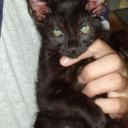

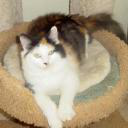

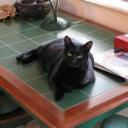

In [2]:
data_dir = pathlib.Path('./data/images')
cats = list(data_dir.glob('train/0/*'))

for image_path in cats[:3]:
    display.display(Image.open(str(image_path)))

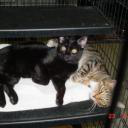

0

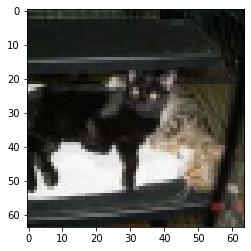

In [4]:
IMG_HEIGHT, IMG_WIDTH = 64, 64
CLASSES = ['0','1']

def create_dataset(path):
    # просто выковыривает имена файлов зная что верхние папки  - классы, а нижние - данные
    list_ds = tf.data.Dataset.list_files(str(path + '*/*'))
    return list_ds

def get_label(file_path):
    splits = tf.strings.split(file_path, '/')
    label = tf.argmax(tf.cast(CLASSES == splits[-2], dtype=tf.float32))
    return label

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3) # TODO 2b
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32) # TODO 2b
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)

    img = tf.io.read_file(file_path) # TODO 2c
    img = decode_img(img)
    return img, label

# это картинка как карттинка
display.display(Image.open(b'./data/images/train/0/3897.jpg'))

# это картинка, уже преобразованная в тензор
plt.imshow(decode_img(tf.io.read_file('./data/images/train/0/3897.jpg')))

# а это метка к этой картинке
get_label(b'./data/train/0/3897.jpg').numpy()

In [13]:
train_ds = create_dataset('./data/images/train/')
train_ds = train_ds.map(process_path).shuffle(32).batch(32).cache()

val_ds = create_dataset('./data/images/test/')
val_ds = val_ds.map(process_path).batch(32)

### !!! очень важно задать бач !
# Если не задать бач - модель будет готовить что инпут шейп не совпадает

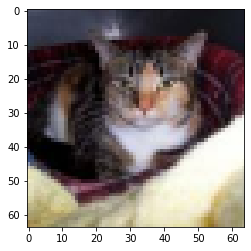

In [14]:
for pic, label in train_ds.take(1):
    plt.imshow(pic[0])

## Модель на Керасе

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32 , (3,3), activation='relu', input_shape=(64,64,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64 , (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64 , (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 4, 4, 128)        

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/',
                                               save_weights_only=True,
                                               save_best_only=False)
model.fit_generator(train_ds, epochs=30, 
          steps_per_epoch=380, 
          validation_data=val_ds,  # можно уже в процессе обученияпроверять
          callbacks=[TensorBoard('./tb-log'), checkpoint])

Epoch 1/30
 13/380 [>.............................] - ETA: 21:42 - loss: 0.6968 - accuracy: 0.4904

In [19]:
#%load_ext tensorboard
#%tensorboard --logdir ./tb-log

In [ ]:
model.evaluate(val_ds)

In [11]:
model.load_weights('./checkpoints/')